In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
from utils import *

In [10]:
G = generate_low_degree_g()
max_out_degree = max(G.out_degree, key=lambda d: d[1])[1]
print(max_out_degree)
print(G.number_of_nodes())
print(G.number_of_edges())

4
20
61


In [13]:
def extract_path(prev, src, dst):
    
    path = []
    u = dst

    while prev[u] != -1:
        path.insert(0, u)
        u = prev[u]
        
    path.insert(0, src)
    return path

def my_dijkstra_path(G, src, dst=None):
    
    prev = [-1 for _ in range(G.number_of_nodes())]
    distance = [float('Inf') for _ in range(G.number_of_nodes())]
    distance[src] = 0
    Q = {}
    intermediate_paths = {}
    
    for node, dist in enumerate(distance):
        Q[node] = dist
        intermediate_paths[node] = []
    
    while len(Q) != 0:
        
        u = min(Q, key=Q.get)
        del Q[u]
        
        for out_edge in G.out_edges(u):
            
            
            v = out_edge[1]
            new_dist = distance[u] + G.get_edge_data(u, v)['weight']
            
#             intermediate_paths[v] += 1
            
            if new_dist < distance[v]:
                distance[v] = new_dist
                Q[v] = new_dist
                prev[v] = u
                
                # extract the tmp path for v here for analysis
                # TODO
                
                intermediate_paths[v].append(extract_path(prev, src, v))
                
    return extract_path(prev, src, dst), intermediate_paths

In [54]:
for node in G.nodes:

    src, dst = node, 1
    paths_from_src = nx.single_source_dijkstra_path(G, src)

    out_neighbor_chosen_count = {}

    for dst, path in paths_from_src.items():
        if len(path) < 2:
            continue

        assert path[-1] == dst

        out_neighbor_chosen_count[path[1]] = 1 if path[1] not in out_neighbor_chosen_count \
                                                else out_neighbor_chosen_count[path[1]] + 1

    print(src)
    for edge in G.out_edges(src):
        print(edge[1], G.get_edge_data(src, edge[1])['weight'], out_neighbor_chosen_count.get(edge[1], 0))


0
(8, 0.7988987431569623, 2)
(1, 0.0016825449131712134, 12)
(7, 0.40208715303288256, 5)
1
(9, 0.9471796802391813, 3)
(10, 0.8183933284450435, 7)
(11, 0.6478491895600348, 5)
(13, 0.49906199533631324, 4)
2
(10, 0.6483183058788682, 0)
(4, 0.13812348633405336, 19)
3
(16, 0.919573860944931, 5)
(2, 0.35827385955151225, 14)
(4, 0.9115758295709423, 0)
4
(10, 0.3346741571045697, 8)
(6, 0.021367315394909103, 11)
5
(8, 0.3237285031289421, 13)
(18, 0.55539167158387, 1)
(10, 0.5695698173306601, 5)
6
(17, 0.4851821976317737, 6)
(13, 0.01843267237920454, 2)
(1, 0.03683929643961226, 11)
7
(2, 0.5881920670078592, 7)
(13, 0.9069245888470042, 0)
(14, 0.9301636054441881, 2)
(5, 0.3398227982910139, 10)
8
(0, 0.23231205894863893, 10)
(19, 0.8862712024569869, 5)
(6, 0.2560798842167836, 4)
9
(1, 0.7189131406352223, 0)
(4, 0.06011936393589723, 19)
(6, 0.6595359116888803, 0)
10
(8, 0.35635275110347475, 10)
(1, 0.45146832892864786, 3)
(14, 0.5617824775246608, 2)
(15, 0.16114852837153792, 4)
11
(0, 0.857933099281

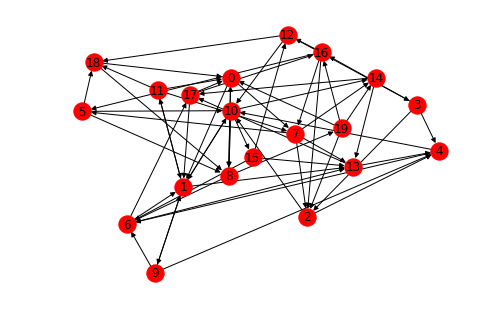

In [27]:
plot_g(G)